In [161]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from dtreeviz.trees import dtreeviz
from sklearn import tree
import seaborn as sns
import graphviz
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [44]:
data_2019 = pd.read_csv('data_2019_1.csv')
#data_2020 = pd.read_csv('data_2020_1.csv')
hourly_2019 = pd.read_csv('normals_hourly_2019.csv')
#hourly_2020 = pd.read_csv('normals_hourly_2020.csv')
oasis_2019 = pd.read_csv('OASISfile-2019.csv')
#oasis_2020 = pd.read_csv('OASISfile-2020.csv')

In [45]:
def formattingLoadFiles(data):
    temp_df = pd.DataFrame()
    for index, row in data.iterrows():
        if '-' in data.loc[index,'Row Labels']:
            val = index
            temp = data[val+1:val+25]
            date = data.loc[index,'Row Labels']
            temp['Row'] = temp['Row Labels'].apply(lambda x: date + ' '+x)
            temp_df = pd.concat([temp_df,temp])
    return temp_df

In [46]:
df_2019 = formattingLoadFiles(data_2019)
#df_2020 = formattingLoadFiles(data_2020)

C:\Users\varal\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
print(df_2020.shape)
print(hourly_2020.shape)
print(oasis_2020.shape)

(8784, 3)
(8760, 6)
(8784, 8)


In [48]:
print(df_2019.shape)
print(hourly_2019.shape)
print(oasis_2019.shape)

(8760, 3)
(8760, 6)
(8760, 8)


In [49]:
hourly_2020.head(2)

,STATION,DATE,DATE.1,HLY-DEWP-NORMAL,HLY-PRES-NORMAL,HLY-TEMP-NORMAL
0,USW00014732,01-01T00:00:00,01-01T00:00:00,22.5,1.0,33.9
1,USW00014732,01-01T01:00:00,01-01T01:00:00,23.5,1.0,34.5


In [50]:
len(list(set(list(hourly_2020['DATE']))))

8760

In [39]:
df_2020.head(2)

,Row Labels,Average of RTD Actual Load,Row
1,12 AM,4912.181818,1-Jan 12 AM
2,1 AM,4782.291667,1-Jan 1 AM


In [94]:
# performing analysis on 2019 data
final_df = pd.DataFrame()
final_df['RTD Actual Load'] = list(df_2019['Average of RTD Actual Load'])
final_df['HLY-DEWP-NORMAL'] = list(hourly_2019['HLY-DEWP-NORMAL'])
final_df['HLY-PRES-NORMAL'] = list(hourly_2019['HLY-PRES-NORMAL'])
final_df['HLY-TEMP-NORMAL'] = list(hourly_2019['HLY-TEMP-NORMAL'])
final_df['DAM Zonal LBMP'] = list(oasis_2019['DAM Zonal LBMP'])
final_df['DAM Zonal Losses'] = list(oasis_2019['DAM Zonal Losses'])
final_df['DAM Zonal Congestion'] = list(oasis_2019['DAM Zonal Congestion'])
final_df['Date'] = list(oasis_2019['Eastern Date Hour'])

#### Data Analysis and Pre-processing

In [76]:
final_df.isna().sum()

RTD Actual Load         0
HLY-DEWP-NORMAL         0
HLY-PRES-NORMAL         0
HLY-TEMP-NORMAL         0
DAM Zonal LBMP          0
DAM Zonal Losses        0
DAM Zonal Congestion    0
Date                    0
dtype: int64

In [90]:
### Model training and tuning

In [88]:
# train test split
y = final_df['RTD Actual Load']
X = final_df.drop(columns = ['RTD Actual Load','Date', 'HLY-PRES-NORMAL'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

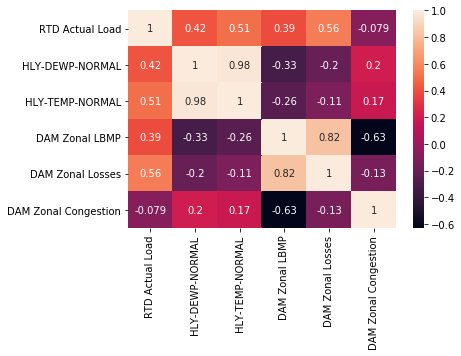

In [165]:
tenp = final_df.drop(columns = ['HLY-PRES-NORMAL'])
corrmatrix = temp.corr()
sns.heatmap(corrmatrix,annot=True)

In [89]:
# Linear regression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.6790444453867821

In [132]:
# decision tree classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
dt = DecisionTreeRegressor().fit(X_train, y_train)
print('R-square   '+ str(dt.score(X_test, y_test)))

R-square   0.8357099167662492


In [116]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)
print('R-square   '+ str(rf.score(X_test, y_test)))

R-square   0.9135463601423462


In [115]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor().fit(X_train, y_train)
print('R-square   '+ str(clf.score(X_test, y_test)))

R-square   0.8670138118168893


## Interpreting the RF results

Text(0, 0.5, 'Realtive importance')

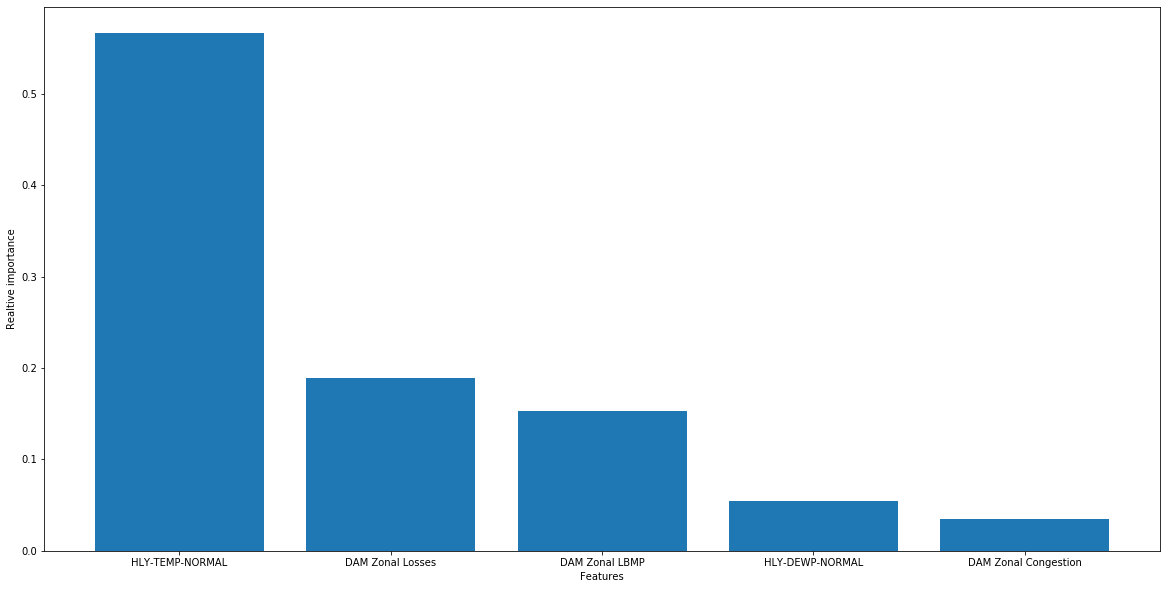

In [119]:
names = list(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
new_indices = indices[:20]
features = X_train.columns[indices]
indices = rf.feature_importances_[indices]
features = list(features[:])
indices = list(indices[:])
plt.figure(figsize=(20, 10))
plt.bar(features, indices)
plt.xlabel('Features')
plt.ylabel('Realtive importance')

In [125]:
# change in r-square with top features
acc = []
for i in range(1,len(features)+1):
    R = RandomForestRegressor()
    R.fit(X_train[features[:i]],y_train)
    acc.append(R.score(X_test[features[:i]], y_test))

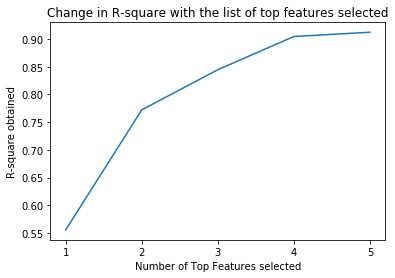

In [130]:
plt.plot(list(range(1,6)),acc)
plt.xlabel('Number of Top Features selected')
plt.ylabel('R-square obtained')
plt.title('Change in R-square with the list of top features selected')
plt.xticks([1,2,3,4,5])
plt.show()

## Interpreting decsion tree results

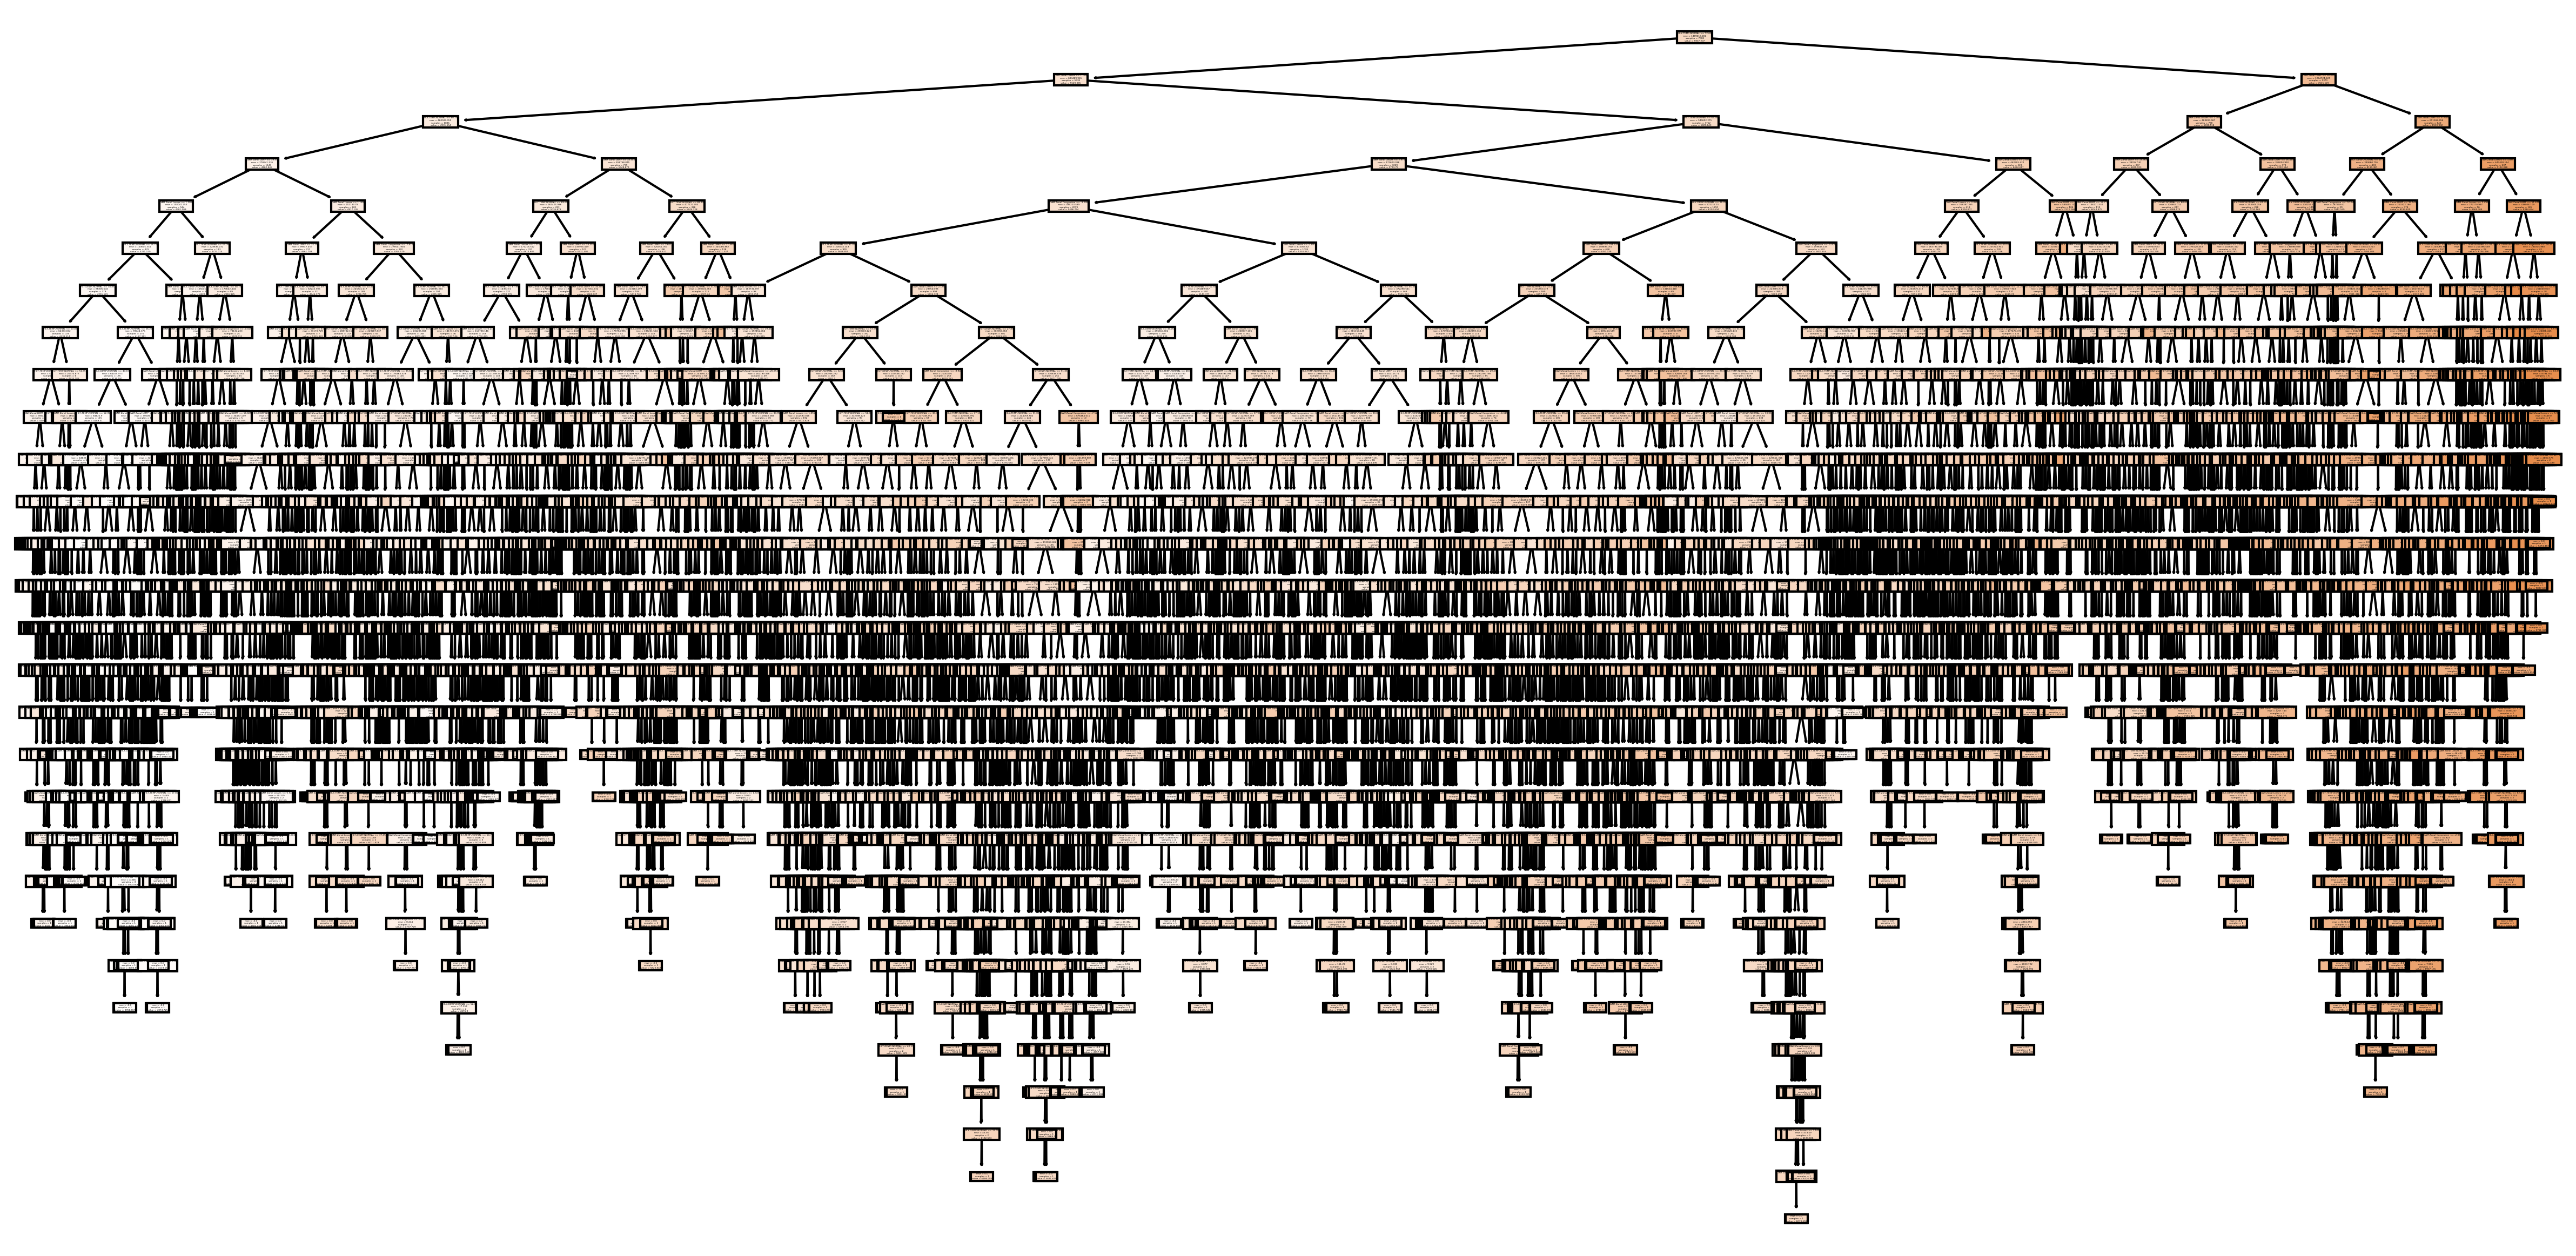

In [160]:
fn=list(X_train.columns)
cn='Average of RTD Actual Load'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10), dpi=300)
tree.plot_tree(dt,
               feature_names = fn, 
               class_names=cn,
               filled = True);
